In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import h5py
import seaborn as sns
from sklearn import datasets
    
import random
import math
import json

In [8]:
sys.path.insert(0, os.getcwd())
from deviance import explained_deviance

### Deviance explained $D^2$

In [9]:
y_true = np.random.randint(0,2,100)
print("sanity check. D2 should be 1.0 when y_pred = y_true. We get D2 = {:.2f}.".format(
    explained_deviance(y_true, y_pred_probas=y_true)))

sanity check. D2 should be 1.0 when y_pred = y_true. We get D2 = 1.00.


### Extensively test all edge cases: 
1. when predictions are perfect 
2. when predictions are exactly opposite

In [10]:
from sklearn.preprocessing import OneHotEncoder

for n_classes in range(2,10):
    print('-'*30, f"\nclasses n={n_classes}" )
    y_true = np.random.randint(0,n_classes+1,1000)
    print(f"perfect prediction (y_true = y_pred):")
    y_pred_probas = OneHotEncoder().fit(y_true.reshape(-1,1)).transform(y_true.reshape(-1,1)).toarray()
    d2 = explained_deviance(y_true, y_pred_probas=y_pred_probas)
    d2_logits = explained_deviance(y_true, y_pred_logits=y_pred_probas*1000)
    print(f"Probas = {d2:.6f} \t logits = {d2_logits:.6f}")
    print(f"perfectly incorrect prediction (y_true = not(y_pred)):")
    y_pred_probas = np.roll(y_pred_probas, 1, -1)
    d2 = explained_deviance(y_true, y_pred_probas=y_pred_probas)
    d2_logits = explained_deviance(y_true, y_pred_logits=y_pred_probas*1000)
    print(f"Probas = {d2:.6f} \t logits = {d2_logits:.6f}")
    print(f"y_pred is always average (1/n_classes)")
    y_pred_probas = np.full_like(y_pred_probas, fill_value=1/n_classes)
    d2 = explained_deviance(y_true, y_pred_probas=y_pred_probas)
    d2_logits = explained_deviance(y_true, y_pred_logits=y_pred_probas*1000)
    print(f"Probas = {d2:.6f} \t logits = {d2_logits:.6f}")


------------------------------ 
classes n=2
perfect prediction (y_true = y_pred):
Probas = 1.000000 	 logits = 1.000000
perfectly incorrect prediction (y_true = not(y_pred)):
Probas = -30.461159 	 logits = -24.168927
y_pred is always average (1/n_classes)
Probas = -0.000719 	 logits = -0.000719
------------------------------ 
classes n=3
perfect prediction (y_true = y_pred):
Probas = 1.000000 	 logits = 1.000000
perfectly incorrect prediction (y_true = not(y_pred)):
Probas = -23.924648 	 logits = -18.939718
y_pred is always average (1/n_classes)
Probas = -0.000409 	 logits = -0.000409
------------------------------ 
classes n=4
perfect prediction (y_true = y_pred):
Probas = 1.000000 	 logits = 1.000000
perfectly incorrect prediction (y_true = not(y_pred)):
Probas = -20.478072 	 logits = -16.182458
y_pred is always average (1/n_classes)
Probas = -0.000835 	 logits = -0.000835
------------------------------ 
classes n=5
perfect prediction (y_true = y_pred):
Probas = 1.000000 	 logits = 1

### Synthetic data: how does the probability value effect the D2?



/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


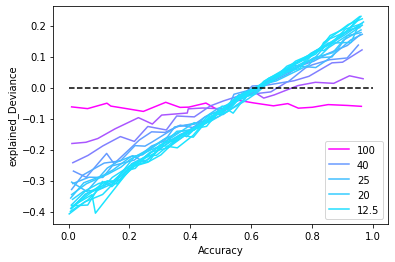

In [11]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import time

# create binary labels with increasing correlation between y_true and y_pred_probas
n_classes = 2
for proba_noise_mul in np.arange(1, 10, 0.5):
    proba_noise = 1/(proba_noise_mul)
    accs = []
    d2s = []
    for corr in np.arange(0.01, 1.01, 0.05):
        y_true = np.random.randint(0,2,1000)
        mask_valreverse = np.random.choice([True, False], size=y_true.shape, p=[1-corr, corr])
        y_pred = y_true.copy()

        # reverse values of some y proportional to the corr
        y_pred[mask_valreverse] =  np.logical_not(y_true[mask_valreverse].astype(bool)).astype(int)
        acc = balanced_accuracy_score(y_true, y_pred)
        accs.extend([acc])
        # convert y_pred to y_pred_probas by adding random noise
        y_pred_probas = y_pred.copy().astype(float)
        # print(y_pred, y_pred_logits[~y_pred.astype(bool)], len(y_pred_logits[~y_pred.astype(bool)]))
        y_pred_probas[y_pred.astype(bool)] -= np.random.sample(y_pred[y_pred.astype(bool)].shape)*proba_noise
        y_pred_probas[~y_pred.astype(bool)] += np.random.sample(y_pred[~y_pred.astype(bool)].shape)*proba_noise
        # plt.hist(y_pred_probas)
        # plt.show()
        # print(f"The y_pred_logits values range from [{y_pred_probas.min():.2f},{y_pred_probas.max():.2f}]")
        # print(((y_pred_probas>0.5).astype(int) == y_pred).sum())
        d2 = explained_deviance(y_true, y_pred_logits=y_pred_probas)
        d2s.extend([d2])
        # print("Accuracy (bal) = {:.2f} % \t D2 explained = {:.2f} %".format(acc*100, d2*100))
    g = sns.lineplot(x=accs, y=d2s, 
                     hue=proba_noise*100, palette="cool", hue_norm=(0,100),
                     legend='brief')
    # print(f"The D2 values range from [{np.array(d2s).min():.2f},{np.array(d2s).max():.2f}] for proba_noise={proba_noise:.2f}")

sns.lineplot(np.arange(0,1.1,0.1), 11*[0], color='k', ls='--')
g.set(xlabel='Accuracy', ylabel='explained_Deviance')
plt.show()

### Test against gonzalo's computed scores

In [13]:
import statsmodels.api as sm
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax, expit


with open("test_data_deviance.json", 'r') as f:
    test_data = json.load(f)
  
    for test_data_k, test_data_v in test_data.items():
        print(f"{'-'*50}\nTest data : {test_data_k}")
        
        y_true = test_data_v['y_true']
        # parse from str form to a list of y values
        y_true = np.array([float(n.strip()) for n in y_true.replace('[','').replace(']','').split(' ')]).astype(int)

        y_pred_logits = np.array(test_data_v['y_pred'])
         # get the predicted label
        if y_pred_logits.ndim > 1: # multiclass
            y_pred = np.argmax(y_pred_logits, axis=-1)
            n_classes = y_pred_logits.shape[-1]
        else: 
            y_pred = (expit(y_pred_logits)>=0.5).astype(int)
            n_classes = 2
        # calculate balanced accuracy
        assert len(y_true) == len(y_pred)
        print("Accuracy (bal) = {:.2f} % \t (chance at {:.1f}%)".format(balanced_accuracy_score(y_true, y_pred)*100, 100/n_classes))
        
        # calculate deviance explained
        # convert to torch tensor to make it compatible
        d2, lls = explained_deviance(y_true, y_pred_logits=y_pred_logits, returnloglikes=True)
        print("D2 explained (ours) = {:.6f} \t llf={:.2f},  llnull={:.2f}".format(d2, lls['loglike_model'], lls['loglike_null']))
        print("D2 explained (old) = {:.6f} \t\t llf={:.2f},  llnull={:.2f}".format(test_data_v["d2_old"], test_data_v["llmodel"], test_data_v["llnull"]))

--------------------------------------------------
Test data : alcfreq_epoch0
Accuracy (bal) = 16.44 % 	 (chance at 16.7%)
D2 explained (ours) = -0.106029 	 llf=-175.89,  llnull=-159.03
D2 explained (old) = -6.455936 		 llf=2671.85,  llnull=358.35
--------------------------------------------------
Test data : alcfreq_epochlast
Accuracy (bal) = 20.27 % 	 (chance at 16.7%)
D2 explained (ours) = -0.083695 	 llf=-180.15,  llnull=-166.23
D2 explained (old) = -7.565448 		 llf=3069.44,  llnull=358.35
--------------------------------------------------
Test data : rightear_epoch0
Accuracy (bal) = 30.91 % 	 (chance at 33.3%)
D2 explained (ours) = -0.283860 	 llf=-106.55,  llnull=-82.99
D2 explained (old) = -0.300531 		 llf=2.86,  llnull=2.20
--------------------------------------------------
Test data : rightear_epochlast
Accuracy (bal) = 31.63 % 	 (chance at 33.3%)
D2 explained (ours) = -0.380722 	 llf=-104.26,  llnull=-75.51
D2 explained (old) = -1.660220 		 llf=5.85,  llnull=2.20
------------

### Compare our results against Statsmodel 
Ground truth evaluation on some real world data

In [310]:
testdata = pd.read_csv("trialALC.csv")

h_reps = testdata[['Rep_ResNet50DeepRepViz-alcintfreq-run0_X',
       'Rep_ResNet50DeepRepViz-alcintfreq-run0_Y',
       'Rep_ResNet50DeepRepViz-alcintfreq-run0_Z']].values
y_true = testdata['Alc_int_freq'].values.astype(int)
y_pred_probas = testdata[['Pred_ResNet50DeepRepViz-alcintfreq-run0_class0',
                   'Pred_ResNet50DeepRepViz-alcintfreq-run0_class1',
                   'Pred_ResNet50DeepRepViz-alcintfreq-run0_class2',
                   'Pred_ResNet50DeepRepViz-alcintfreq-run0_class3',
                   'Pred_ResNet50DeepRepViz-alcintfreq-run0_class4',
                   'Pred_ResNet50DeepRepViz-alcintfreq-run0_class5']].values

# testdata = pd.read_csv("trialSRT.csv")
# h_reps = testdata[[
#        'Rep_ResNet50DeepRepViz-srtrightearclassification-run2_X',
#        'Rep_ResNet50DeepRepViz-srtrightearclassification-run2_Y',
#        'Rep_ResNet50DeepRepViz-srtrightearclassification-run2_Z']].values
# y_true = testdata['srt_right_ear_classification'].values.astype(int)
# y_pred_probas = testdata[
#       ['Pred_ResNet50DeepRepViz-srtrightearclassification-run2_class0',
#        'Pred_ResNet50DeepRepViz-srtrightearclassification-run2_class1',
#        'Pred_ResNet50DeepRepViz-srtrightearclassification-run2_class2',]].values
# print("y_true values:")
pd.Series(y_true).value_counts().sort_index()

0    1330
1    2298
2    2141
3     929
4     823
5     479
dtype: int64

In [311]:
n_classes = y_pred_probas.shape[-1]
y_pred_DL_probas = np.argmax(y_pred_probas, -1)

# deviance score after fitting a logit model from statsmodel
# if n_classes>2:
#     y_pred = OneHotEncoder(sparse=False).fit_transform(y_pred.reshape(-1,1))
# else:
#     logit = sm.Logit

h_reps = sm.add_constant(h_reps, prepend=False)
start = time.process_time()
d2_glm = sm.MNLogit(y_true, h_reps).fit() 
print("(runtime:: {:.5f})".format(time.process_time() - start))
# d2_glm = sm.GLM(y_true, h_reps, family=sm.families.Binomial()).fit() 
display(d2_glm.summary())

y_pred_glm_probas = d2_glm.predict(h_reps)
y_pred_glm = np.argmax(y_pred_glm_probas, -1)

# ground truth as accuracy 
print("MNLogit Accuracy (bal) = {:.2f} % \t (chance at {:.1f}%)".format(
    balanced_accuracy_score(y_true, y_pred_glm)*100, 
    100/n_classes))

print("MNLogit D2 explained  (sm)  = {:.6f} \t\t\t\t llf={},  llnull={}".format(
    d2_glm.prsquared, d2_glm.llf, d2_glm.llnull))
# our deviance score
start = time.process_time()
d2, lls  = explained_deviance(y_true, y_pred_probas=y_pred_glm_probas, returnloglikes=True)
print("MNLogit D2 explained (ours) = {:.6f}  (runtime:: {:.5f}) \t llf={},  llnull={}".format(
    d2, time.process_time()-start, lls['loglike_model'], lls['loglike_null']))

Optimization terminated successfully.
         Current function value: 1.641724
         Iterations 6
(runtime:: 1.65429)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                 8000
Model:                        MNLogit   Df Residuals:                     7980
Method:                           MLE   Df Model:                           15
Date:                Fri, 02 Dec 2022   Pseudo R-squ.:                 0.01217
Time:                        11:18:24   Log-Likelihood:                -13134.
converged:                       True   LL-Null:                       -13296.
Covariance Type:            nonrobust   LLR p-value:                 6.521e-60
==============================================================================
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3239      0.775      2.999      0.003       0.805       3.843
x2             2.4355      0.827      2.944      0.003       0.814       4.057
x3            -0.5799      0.727     -0.798      0.425      -2.004       0.844
const          0.1281      0.105      1.224      0.221      -0.077       0.333
------------------------------------------------------------------------------
       y=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3185      0.762      3.042      0.002       0.825       3.812
x2             2.6999      0.810      3.331      0.001       1.112       4.288
x3            -0.6452      0.715     -0.902      0.367      -2.047       0.757
const         -0.1829      0.107     -1.708      0.088      -0.393       0.027
------------------------------------------------------------------------------
       y=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1743      0.883      1.329      0.184      -0.557       2.906
x2             2.0711      0.938      2.209      0.027       0.233       3.909
x3            -1.2683      0.837     -1.515      0.130      -2.909       0.372
const         -0.9355      0.131     -7.142      0.000      -1.192      -0.679
------------------------------------------------------------------------------
       y=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1035      0.899      0.115      0.908      -1.659       1.866
x2             1.4715      0.957      1.537      0.124      -0.405       3.348
x3            -1.9787      0.864     -2.290      0.022      -3.672      -0.285
const         -0.9073      0.135     -6.725      0.000      -1.172      -0.643
------------------------------------------------------------------------------
       y=5       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3645      1.139      0.320      0.749      -1.867       2.596
x2             1.6782      1.228      1.367      0.172      -0.728       4.085
x3            -2.7446      1.116     -2.459      0.014      -4.932      -0.557
const         -1.0535      0.158     -6.649      0.000      -1.364      -0.743
==============================================================================
"""

MNLogit Accuracy (bal) = 18.22 % 	 (chance at 16.7%)
MNLogit D2 explained  (sm)  = 0.012173 				 llf=-13133.790432887896,  llnull=-13295.64026258147
MNLogit D2 explained (ours) = 0.012173  (runtime:: 0.22565) 	 llf=-13133.790432887894,  llnull=-13295.640262109953
